# Klassifikation der in gensim vektorisierten Daten (all_labels) 

Autorin: Maria Hartmann

In [46]:
# Imports
import os
import time
import pandas as pd
import numpy as np
import scipy.sparse
from matplotlib import pyplot
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard


Einlesen der vektorisierten Daten

In [2]:
trainset_labels = '../Datasets/all_labels_gensim_train_idents_labels.csv' 
testset_labels = '../Datasets/all_labels_gensim_test_idents_labels.csv' 

trainset_csv = pd.read_csv(trainset_labels, delimiter=';')
y_train = trainset_csv['classes'].values
z_train = trainset_csv['url'].values
train_vectors = trainset_csv['filename'].values

testset_csv = pd.read_csv(testset_labels, delimiter=';')
y_test = testset_csv['classes'].values
z_test = testset_csv['url'].values
test_vectors = testset_csv['filename'].values

# Splitten der Labels pro Blogbeitrag
y_train = [e.split(', ') for e in y_train]
y_test = [e.split(', ') for e in y_test]

In [3]:
if len(set(train_vectors)) == 1:
    X_train = scipy.sparse.load_npz('../%s' % train_vectors[0])
else:
    print("Error with len(set(train_vectors))")
if len(set(test_vectors)) == 1:
    X_test = scipy.sparse.load_npz('../%s' % test_vectors[0])
else:
    print("Error with len(set(test_vectors))")

In [4]:
print(z_train[0])
print(y_train[0])
print(test_vectors[0])
print(X_train.shape)
X_train

nummer.hypotheses.org/212
['histoire_d', "sciences de l'information et de la communication_d", 'bibliothéconomie_d', 'histoire_t', 'histoire intellectuelle_t', 'histoire et sociologie des médias_t', 'histoire culturelle_t']
Datasets/all_labels_test_gensim_sparse_matrix.npz
(17109, 10000)


<17109x10000 sparse matrix of type '<class 'numpy.float32'>'
	with 171090000 stored elements in Compressed Sparse Row format>

In [5]:
dim = X_train.shape[1]
print(dim)

10000


In [6]:
output_dir = "../all_labels_gensim" 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

k-hot-Kodierung der Labels

In [7]:
# k-hot-encode labels mit MultiLabelBinarizer
label_encoder = MultiLabelBinarizer()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)
print(encoded_y_train[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [8]:
print(len(label_encoder.classes_))
for i, element in enumerate(label_encoder.classes_):
    print(i, element)

114
0 1914-1918_t
1 1918-1939_t
2 1939-1945_t
3 1945-1989_t
4 administration publique et développement_d
5 anthropologie politique_t
6 approches de corpus_t
7 archives_t
8 archéologie_d
9 arts et humanités_d
10 arts_d
11 asie_t
12 bas moyen âge_t
13 bibliothéconomie_d
14 biomédecine_d
15 chine_t
16 communication_d
17 conflits_t
18 digital humanities_t
19 enquêtes_t
20 europe centrale et orientale_t
21 europe_t
22 france_t
23 guerres_t
24 haut moyen âge_t
25 histoire culturelle_t
26 histoire de l'art_t
27 histoire des religions_t
28 histoire des sciences sociales_d
29 histoire des sciences_t
30 histoire du droit_t
31 histoire et archéologie_d
32 histoire et philosophie des sciences_d
33 histoire et sociologie des médias_t
34 histoire industrielle_t
35 histoire intellectuelle_t
36 histoire politique_t
37 histoire sociale_t
38 histoire urbaine_t
39 histoire économique_t
40 histoire_d
41 histoire_t
42 historiographie_t
43 humanités pluridisciplinaires_d
44 information_t
45 langage_t
46 lan

# Klassifikation mit MLPClassifier

In [9]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(4096,1024), validation_fraction=0.1, early_stopping=True, verbose=True, random_state=1)
mlp_start = time.time()
mlp_clf = mlp_clf.fit(X_train, encoded_y_train)
mlp_time = (time.time() - mlp_start)/60

Iteration 1, loss = 13.27183478
Validation score: 0.424313
Iteration 2, loss = 7.81454582
Validation score: 0.462303
Iteration 3, loss = 6.31582659
Validation score: 0.505552
Iteration 4, loss = 5.14183384
Validation score: 0.514319
Iteration 5, loss = 4.17049948
Validation score: 0.527177
Iteration 6, loss = 3.24715438
Validation score: 0.552893
Iteration 7, loss = 2.45858781
Validation score: 0.541204
Iteration 8, loss = 1.80384178
Validation score: 0.545880
Iteration 9, loss = 1.31066464
Validation score: 0.542373
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


In [10]:
print(mlp_time)
mlp_predicted = mlp_clf.predict(X_test)

146.55854127407073


In [11]:
mlp_precision = precision_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_precision)
mlp_recall = recall_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_recall)
mlp_f1 = f1_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_f1)

0.8140133553527662
0.7606179759931513
0.7693825399986833


c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[13.271834778551858, 7.814545815769524, 6.315826593383843, 5.141833835170679, 4.170499484138123, 3.2471543776046214, 2.458587810087377, 1.803841780445036, 1.31066463792114]


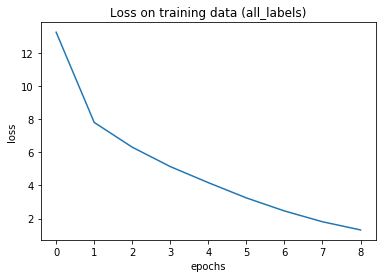

In [13]:
loss_values = mlp_clf.loss_curve_
print(loss_values)
pyplot.title('Loss on training data (all_labels)')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.plot(loss_values)
pyplot.savefig('%s/all_labels_gensim_mlp_plot_loss.png' % output_dir)
pyplot.show()

[0.4243132670952659, 0.46230274693161894, 0.5055523085914669, 0.5143191116306254, 0.527177089421391, 0.5528930450029222, 0.5412039742840444, 0.5458796025715955, 0.5423728813559322]


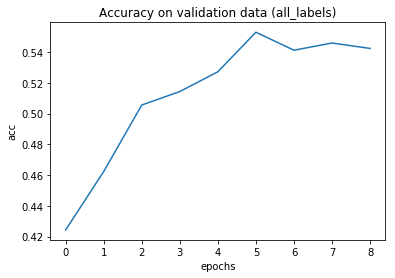

In [14]:
validation_scores = mlp_clf.validation_scores_
print(validation_scores)
pyplot.title('Accuracy on validation data (all_labels)')
pyplot.xlabel('epochs')
pyplot.ylabel('acc')
pyplot.plot(validation_scores)
pyplot.savefig('%s/all_labels_gensim_mlp_plot_val_acc.png' % output_dir)
pyplot.show()

Vergleich zwischen der Vektorisierung in scikit-learn und gensim (Klassifikation mit dem MLPClassifier von all_labels)

In [18]:
loss_values_scikit_learn = [19.21366700374499, 9.467989909749473, 5.495542813416394, 2.980149101333112, 1.6234586937668352, 0.9450190023217871, 0.6229070227073472, 0.4846545875629756, 0.4053494018358509]
validation_scores_scikit_learn = [0.38457042665108127, 0.45879602571595557, 0.5137346580946814, 0.5406195207481005, 0.5429573348918761, 0.5441262419637639, 0.5417884278199883, 0.5388661601402689, 0.5423728813559322]

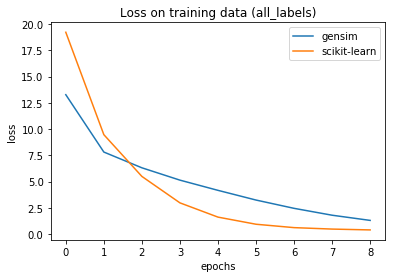

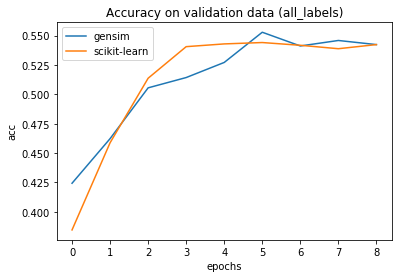

In [19]:
pyplot.title('Loss on training data (all_labels)')
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.plot(loss_values, label='gensim')
pyplot.plot(loss_values_scikit_learn, label='scikit-learn')
pyplot.legend()
pyplot.savefig('%s/all_labels_mlp_plot_loss_comparison.png' % output_dir)
pyplot.show()


pyplot.title('Accuracy on validation data (all_labels)')
pyplot.xlabel('epochs')
pyplot.ylabel('acc')
pyplot.plot(validation_scores, label='gensim')
pyplot.plot(validation_scores_scikit_learn, label='scikit-learn')
pyplot.legend()
pyplot.savefig('%s/all_labels_mlp_plot_val_acc_comparison.png' % output_dir)
pyplot.show()

# Klassifikation mit Dense-Layer in Keras

In [31]:
count=0

In [33]:
# MLP in Keras  

dense_model = Sequential()
dense_model.add(Dense(4096, input_dim=dim, activation="relu"))
#dense_model.add(Dropout(0.4))
#dense_model.add(Dropout(0.4))
#dense_model.add(Dropout(0.4))
dense_model.add(Dense(1024, activation="relu"))
#dense_model.add(Dropout(0.4))
#dense_model.add(Dropout(0.4))
#dense_model.add(Dropout(0.4))
dense_model.add(Dense(len(label_encoder.classes_), activation="sigmoid"))

summary = dense_model.summary()
print("\n", summary)
config = dense_model.get_config()
print("\n", config)

# compile keras model
lossfunction = 'binary_crossentropy'
optimizer = "adam"
metrics = ['accuracy']

dense_model.compile(loss=lossfunction, 
              optimizer=optimizer,
              metrics=metrics)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=7, verbose=10),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=10),
                  TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
                 ]

# train keras model
batch_size = 32
epochs = 100
dense_start = time.time()
dense_estimator = dense_model.fit(X_train,
                            encoded_y_train, 
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=10, 
                            validation_split=0.1,
                            shuffle=True
                           )

dense_time = (time.time() - dense_start)/60
print("Laufzeit in Minuten:", dense_time)
count+=1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 4096)              40964096  
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_16 (Dense)             (None, 114)               116850    
Total params: 45,276,274
Trainable params: 45,276,274
Non-trainable params: 0
_________________________________________________________________

 None

 [{'class_name': 'Dense', 'config': {'name': 'dense_14', 'trainable': True, 'batch_input_shape': (None, 10000), 'dtype': 'float32', 'units': 4096, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}

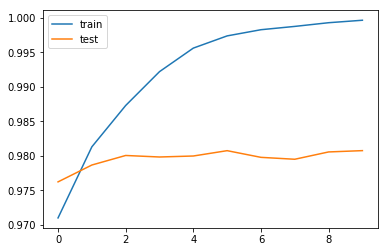

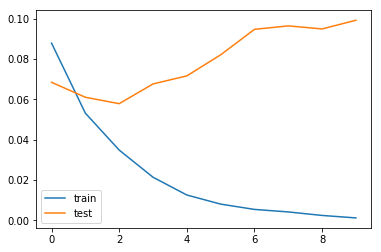

In [34]:
# visualize the train and validate loss and accuracy

# plot history for accuracy
pyplot.plot(dense_estimator.history['acc'], label='train')
pyplot.plot(dense_estimator.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('%s/all_labels_gensim_dense_plot_acc_%s.png' % (output_dir, count))
pyplot.show()
pyplot.close()

# plot history for loss
pyplot.plot(dense_estimator.history['loss'], label='train')
pyplot.plot(dense_estimator.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('%s/all_labels_gensim_dense_plot_loss_%s.png' % (output_dir, count))
pyplot.show()
pyplot.close()

In [35]:
print(dense_time)
dense_predicted = dense_model.predict_proba(X_test)

49.934596784909566


In [36]:
print(dense_predicted[0].round())
print(encoded_y_test[0])

[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [38]:
dense_precision = precision_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_precision)
dense_recall = recall_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_recall)
dense_f1 = f1_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_f1)

0.8358786050581282
0.7803681896774463
0.7928902274783608


c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Ohne Dropout:

Precision: 0.8368304699300492
Recall: 0.7853174771828347
F1-Score: 0.7967917446616334

Mit einer Dropout-Schicht (0,4)

Precision: 0.8364704953765262
Recall: 0.8097225342316505
F1-Score: 0.8126913833496906

Mit drei Dropout-Schichten (0,4):

Precision: 0.817464881490127
Recall: 0.764179040791944
F1-Score: 0.771810034224439

# Klassifikation mit LSTM-Layer in Keras

In [47]:
# LSTM in Keras
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=dim, output_dim=114))
lstm_model.add(LSTM(114))#, dropout=0.4, recurrent_dropout=0.4))
lstm_model.add(Dense(len(label_encoder.classes_), activation="sigmoid"))

summary = lstm_model.summary()
print("\n", summary)
config = lstm_model.get_config()
print("\n", config)

# compile keras model
lossfunction = 'binary_crossentropy'
optimizer = "adam"
metrics = ['accuracy']

lstm_model.compile(loss=lossfunction,
                   optimizer=optimizer,
                   metrics=metrics)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=7, verbose=10),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=10),
                  TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
                 ]

# train keras model
batch_size = 32
epochs = 100
lstm_start = time.time()
lstm_estimator = lstm_model.fit(X_train,
                            encoded_y_train, 
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=10, 
                            validation_split=0.1,
                            shuffle=True
                           )

lstm_time = (time.time() - lstm_start)/60
print("Laufzeit in Minuten:", lstm_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 114)         1140000   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 114)         456       
_________________________________________________________________
lstm_7 (LSTM)                (None, 114)               104424    
_________________________________________________________________
dense_20 (Dense)             (None, 114)               13110     
Total params: 1,257,990
Trainable params: 1,257,762
Non-trainable params: 228
_________________________________________________________________

 None

 [{'class_name': 'Embedding', 'config': {'name': 'embedding_7', 'trainable': True, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 114, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval'

InvalidArgumentError: indices[28,0] = -1 is not in [0, 10000)
	 [[Node: embedding_7/GatherV2 = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@training_11/Adam/gradients/embedding_7/GatherV2_grad/Reshape"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_7/embeddings/read, embedding_7/Cast, lstm_7/TensorArrayUnstack/range/start)]]

Caused by op 'embedding_7/GatherV2', defined at:
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-b18229dee274>", line 3, in <module>
    lstm_model.add(Embedding(input_dim=dim, output_dim=114))
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\models.py", line 497, in add
    layer(x)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\layers\embeddings.py", line 138, in call
    out = K.gather(self.embeddings, inputs)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py", line 1215, in gather
    return tf.gather(reference, indices)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2736, in gather
    return gen_array_ops.gather_v2(params, indices, axis, name=name)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3668, in gather_v2
    "GatherV2", params=params, indices=indices, axis=axis, name=name)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[28,0] = -1 is not in [0, 10000)
	 [[Node: embedding_7/GatherV2 = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@training_11/Adam/gradients/embedding_7/GatherV2_grad/Reshape"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_7/embeddings/read, embedding_7/Cast, lstm_7/TensorArrayUnstack/range/start)]]


In [ ]:
# visualize the train and validate loss and accuracy

# plot history for accuracy
pyplot.plot(lstm_estimator.history['acc'], label='train')
pyplot.plot(lstm_estimator.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('%s/all_labels_gesim_lstm_plot_acc.png' % output_dir)
pyplot.show()
pyplot.close()

# plot history for loss
pyplot.plot(lstm_estimator.history['loss'], label='train')
pyplot.plot(lstm_estimator.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('%s/all_labels_gensim_lstm_plot_loss.png' % output_dir)
pyplot.show()
pyplot.close()

In [ ]:
print(lstm_time)
lstm_predicted = lstm_clf.predict_proba(X_test)

In [ ]:
lstm_precision = precision_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_precision)
lstm_recall = recall_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_recall)
lstm_f1 = f1_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_f1)